In [3]:
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.stats import entropy
from scipy.signal import find_peaks
import torch
from sklearn.metrics import classification_report, confusion_matrix,f1_score, roc_auc_score
from torch import nn
from tqdm import tqdm
import seaborn as sns
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingLR
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import StratifiedKFold,cross_val_score
import torch.optim as optim
from catboost import CatBoostClassifier







device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available()) 
print(device)

True
cuda


In [4]:
def create_db(full_path):
  dataset = []
  labels = []
  for file_name in os.listdir(full_path):
    if file_name.endswith('.hea'):
      continue
    label = os.path.basename(os.path.dirname(full_path))
    labels.append(label)
    data = np.fromfile((os.path.join(full_path,file_name)),dtype = np.int16)
    dataset.append(data)
    df = pd.DataFrame(dataset)
    df['label'] = labels
  return df

In [5]:
df1 = create_db(full_path="C:\\Users\\richk\\OneDrive\\Рабочий стол\\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\\1_Dangerous_VFL_VF\\frag")
df2 =create_db(full_path="C:\\Users\\richk\OneDrive\\Рабочий стол\\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\\2_Special_Form_VTTdP\\frag")
df3 = create_db(full_path="C:\\Users\\richk\\OneDrive\\Рабочий стол\\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\\3_Threatening_VT\\frag")
df4 =create_db(full_path="C:\\Users\\richk\\OneDrive\\Рабочий стол\\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\\4_Potential_Dangerous\\frag")
df5 = create_db(full_path="C:\\Users\\richk\\OneDrive\\Рабочий стол\\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\\5_Supraventricular\\frag")
df6 =create_db(full_path="C:\\Users\\richk\\OneDrive\\Рабочий стол\\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\\6_Sinus_rhythm\\frag")

<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\O'
C:\Users\richk\AppData\Local\Temp\ipykernel_18592\4126605693.py:2: SyntaxWarning: invalid escape sequence '\O'
  df2 =create_db(full_path="C:\\Users\\richk\OneDrive\\Рабочий стол\\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\\2_Special_Form_VTTdP\\frag")


In [6]:
full_dataset = pd.concat([df1,df2,df3, df4, df5, df6], ignore_index=True)
full_dataset = full_dataset.replace(['1_Dangerous_VFL_VF','2_Special_Form_VTTdP','3_Threatening_VT','4_Potential_Dangerous','5_Supraventricular','6_Sinus_rhythm'],[0,1,2,3,4,5])
full_dataset

C:\Users\richk\AppData\Local\Temp\ipykernel_18592\2629379934.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dataset = full_dataset.replace(['1_Dangerous_VFL_VF','2_Special_Form_VTTdP','3_Threatening_VT','4_Potential_Dangerous','5_Supraventricular','6_Sinus_rhythm'],[0,1,2,3,4,5])


,0,1,2,3,4,5,6,7,8,9,...,712,713,714,715,716,717,718,719,720,label
0,180,178,175,172,171,173,175,174,168,156,...,192,198,202,204,202,199,194,191,188,0
1,-191,-191,-192,-195,-200,-204,-202,-197,-189,-179,...,194,176,157,136,109,78,45,11,-20,0
2,-20,-48,-69,-86,-99,-110,-120,-130,-139,-149,...,18,-3,-29,-59,-89,-115,-135,-149,-158,0
3,89,99,107,112,117,121,126,132,137,142,...,-204,-209,-211,-213,-216,-217,-216,-214,-211,0
4,217,224,227,228,229,230,232,234,235,235,...,140,133,127,121,115,110,104,96,88,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,-29,-30,-30,-30,-29,-28,-30,-33,-36,-35,...,25,26,27,26,22,17,12,5,1,5
1012,-75,-75,-74,-75,-76,-75,-73,-71,-68,-66,...,-2,-1,3,4,5,3,1,1,3,5
1013,-73,-75,-73,-70,-69,-71,-72,-73,-73,-72,...,38,36,34,35,36,37,35,31,29,5
1014,16,19,25,27,27,24,21,19,20,21,...,-26,-23,-21,-20,-19,-18,-17,-18,-19,5


In [7]:
def normalize_signals(data):
    scaler = StandardScaler()
    data_normalized = np.zeros_like(data, dtype=np.float32)
    for i in range(data.shape[0]):
        data_normalized[i] = scaler.fit_transform(data[i].reshape(-1, 1)).reshape(-1)
    return data_normalized

-----------------------------------------------------------------------------------------

In [8]:
def create_db1(full_path, numb=15):
  combined_df = pd.DataFrame(columns=[i for i in range(numb+1)] + ['label'])
  for file_name in os.listdir(full_path):
    label = os.path.basename(os.path.dirname(full_path))
    data = pd.read_csv(os.path.join(full_path,file_name), header=None)
    data = data[0].tolist()
    row = data[:len(data)] + [label]
    try:
        combined_df.loc[len(combined_df)] = row
    except:
        print(row, len(row))
  return combined_df

In [9]:
df11 = create_db1(r"C:\Users\richk\OneDrive\Рабочий стол\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\1_Dangerous_VFL_VF\15_2")
df12 = create_db1(r"C:\Users\richk\OneDrive\Рабочий стол\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\2_Special_Form_VTTdP\15_2")
df13 = create_db1(r"C:\Users\richk\OneDrive\Рабочий стол\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\3_Threatening_VT\15_2")
df14 = create_db1(r"C:\Users\richk\OneDrive\Рабочий стол\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\4_Potential_Dangerous\15_2")
df15 = create_db1(r"C:\Users\richk\OneDrive\Рабочий стол\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\5_Supraventricular\15_2")
df16 = create_db1(r"C:\Users\richk\OneDrive\Рабочий стол\ecg-fragment-database-for-the-exploration-of-dangerous-arrhythmia-1.0.0\6_Sinus_rhythm\15_2")
full_dataset_spec = pd.concat([df11,df12,df13, df14, df15, df16], ignore_index=True)

In [10]:
df = pd.DataFrame(full_dataset_spec) 
numeric_columns = df.select_dtypes(include=[np.number]).columns

row_sums = df[numeric_columns].sum(axis=1)

if (row_sums == 0).any():
    raise ValueError("Некоторые спектры имеют нулевую сумму интенсивностей!")


df_normalized = df.copy()
df_normalized[numeric_columns] = df[numeric_columns].div(row_sums, axis=0)
df_normalized

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,label
0,0.500509,0.003944,0.001465,0.020108,0.353323,0.104229,0.004624,0.003921,0.001784,0.000782,0.001613,0.000220,0.000066,0.001069,0.002011,0.000333,1_Dangerous_VFL_VF
1,0.501034,0.000958,0.000307,0.004485,0.002104,0.446605,0.029388,0.000150,0.000578,0.000133,0.005371,0.001318,0.000123,0.000043,0.000631,0.006771,1_Dangerous_VFL_VF
2,0.504155,0.008499,0.001189,0.004717,0.003827,0.197160,0.275896,0.000279,0.000506,0.000080,0.000267,0.003288,0.000013,0.000036,0.000043,0.000045,1_Dangerous_VFL_VF
3,0.501434,0.008014,0.000634,0.009609,0.013945,0.427695,0.023103,0.000275,0.000387,0.000760,0.005770,0.000616,0.000255,0.000260,0.001259,0.005983,1_Dangerous_VFL_VF
4,0.501845,0.016170,0.000965,0.005679,0.059468,0.388257,0.016360,0.000474,0.000795,0.002133,0.001301,0.000734,0.000119,0.000774,0.003706,0.001220,1_Dangerous_VFL_VF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,0.532172,0.078659,0.163871,0.124378,0.002418,0.004443,0.005249,0.015258,0.010414,0.012074,0.007973,0.010889,0.009734,0.009806,0.005549,0.007114,6_Sinus_rhythm
1012,0.527665,0.083837,0.161463,0.140240,0.008756,0.006642,0.005331,0.012771,0.007970,0.008241,0.007373,0.006787,0.006855,0.006800,0.005388,0.003880,6_Sinus_rhythm
1013,0.530357,0.116369,0.161673,0.090933,0.006801,0.003343,0.013240,0.014657,0.003945,0.009201,0.008982,0.008767,0.007886,0.008111,0.008110,0.007626,6_Sinus_rhythm
1014,0.588906,0.009806,0.009397,0.024792,0.029349,0.046225,0.022378,0.017541,0.027613,0.039003,0.027436,0.027174,0.037489,0.037989,0.037566,0.017335,6_Sinus_rhythm


In [11]:
def MMM(data):
    return np.min(data), np.max(data), round(np.mean(data),2)

def zero_cross(data):
  ZC_count = 0
  for i in range(len(data)-1):
    if data[i] > 0  and data[i+1] < 0:
      ZC_count += 1
    if data[i] < 0 and data[i+1] > 0:
      ZC_count += 1
  return ZC_count

def extract_frequency_features(data, fs):
    # Нормализация сигнала
    data = data - np.mean(data)

    # Вычисляем FFT
    N = len(data)
    spectrum = np.abs(fft(data))[:N // 2]   # Берём только положительные частоты
    freqs = np.linspace(0, fs / 2, N // 2)

    # Нормируем спектр (для энтропии и centroid)
    psd = spectrum ** 2
    psd_norm = psd / np.sum(psd + 1e-12)  # +1e-12 — чтобы не делить на 0

    # 🔹 1. Spectral entropy
    spec_entropy = entropy(psd_norm)

    # 🔹 2. Dominant frequency
    dom_freq = freqs[np.argmax(psd)]

    # 🔹 3. Spectral centroid
    centroid = np.sum(freqs * psd_norm)

    return spec_entropy, dom_freq, centroid


def heart_rate(data,fs):
    peaks, _ = find_peaks(data, distance=fs*0.2, height=np.mean(data) + np.std(data))

    rr_intervals_samples = np.diff(peaks)
    rr_intervals_sec = rr_intervals_samples / fs
    heart_rates = 60 / rr_intervals_sec

    mean_hr = np.mean(heart_rates)

    return round(mean_hr, 2)

def preproc_file(full_path, fs = 360):
  features =[]
  for file_name in os.listdir(full_path):
    if file_name.endswith('.hea'):
      continue
    data = np.fromfile((os.path.join(full_path,file_name)), dtype = np.int16)
    min_v , max_v, mean_v = MMM(data)
    HR = heart_rate(data,fs)
    spec_entropy, dom_freq, centroid = extract_frequency_features(data, fs)
    ZC = zero_cross(data)
    features.append({
        "file": file_name,
        "label": os.path.basename(os.path.dirname(full_path)),
        "hr": HR,
        "min": min_v,
        "max": max_v,
        "mean": mean_v,
        "zero_cross": ZC,
        "entropy": spec_entropy,
        "dom_freq": dom_freq,
        "centroid": centroid
    })
  return pd.DataFrame(features)

In [12]:
def preproc_from_dataframe(df, fs=360):
    features = []
    
    # Идем по строкам таблицы
    for index, row in df.iterrows():
        # Получаем сигнал из всех столбцов, за исключением 'label'
        signal = row.drop('label').values  # Сигнал — это все, кроме 'label'
        
        # Применяем функции для извлечения признаков
        min_v, max_v, mean_v = MMM(signal)
        HR = heart_rate(signal, fs)
        spec_entropy, dom_freq, centroid = extract_frequency_features(signal, fs)
        ZC = zero_cross(signal)

        # Добавляем признаки в список
        features.append({
            "hr": HR,
            "min": min_v,
            "max": max_v,
            "mean": mean_v,
            "zero_cross": ZC,
            "entropy": spec_entropy,
            "dom_freq": dom_freq,
            "centroid": centroid
        })
    
    # Создаем DataFrame с признаками
    features_df = pd.DataFrame(features)
    
    # Добавляем лейблы из оригинального DataFrame
    features_df['label'] = df['label']

    return features_df

In [13]:
processed_df = preproc_from_dataframe(full_dataset)
processed_df = processed_df.drop('label',axis =1)



c:\Users\richk\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\richk\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\richk\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\richk\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\richk\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\richk\AppData

In [14]:
X_scaled = normalize_signals(processed_df.values) 
X_scaled_df = pd.DataFrame(processed_df.values,columns=processed_df.columns)
X_scaled_df

,hr,min,max,mean,zero_cross,entropy,dom_freq,centroid
0,247.94,-299.0,238.0,-17.68,16.0,0.812203,4.011142,4.177260
1,213.83,-228.0,260.0,7.80,19.0,1.021716,5.013928,5.329754
2,159.26,-210.0,320.0,21.59,20.0,1.415667,5.515320,5.264376
3,217.10,-233.0,207.0,1.44,19.0,1.734859,5.013928,5.537361
4,206.95,-230.0,235.0,3.64,17.0,2.086808,4.512535,4.728101
...,...,...,...,...,...,...,...,...
1011,154.53,-102.0,139.0,-11.24,13.0,2.388714,1.504178,4.707126
1012,155.29,-83.0,117.0,-6.79,18.0,2.471035,1.504178,5.008852
1013,138.14,-78.0,135.0,-5.63,10.0,2.938972,2.506964,6.313203
1014,76.33,-357.0,633.0,11.93,24.0,3.506330,5.013928,12.115905


In [15]:
X_scaled_df = X_scaled_df.reset_index(drop=True)
df_normalized = df_normalized.reset_index(drop=True)
res_ = pd.concat([X_scaled_df, df_normalized], axis=1)
res_

,hr,min,max,mean,zero_cross,entropy,dom_freq,centroid,0,1,...,7,8,9,10,11,12,13,14,15,label
0,247.94,-299.0,238.0,-17.68,16.0,0.812203,4.011142,4.177260,0.500509,0.003944,...,0.003921,0.001784,0.000782,0.001613,0.000220,0.000066,0.001069,0.002011,0.000333,1_Dangerous_VFL_VF
1,213.83,-228.0,260.0,7.80,19.0,1.021716,5.013928,5.329754,0.501034,0.000958,...,0.000150,0.000578,0.000133,0.005371,0.001318,0.000123,0.000043,0.000631,0.006771,1_Dangerous_VFL_VF
2,159.26,-210.0,320.0,21.59,20.0,1.415667,5.515320,5.264376,0.504155,0.008499,...,0.000279,0.000506,0.000080,0.000267,0.003288,0.000013,0.000036,0.000043,0.000045,1_Dangerous_VFL_VF
3,217.10,-233.0,207.0,1.44,19.0,1.734859,5.013928,5.537361,0.501434,0.008014,...,0.000275,0.000387,0.000760,0.005770,0.000616,0.000255,0.000260,0.001259,0.005983,1_Dangerous_VFL_VF
4,206.95,-230.0,235.0,3.64,17.0,2.086808,4.512535,4.728101,0.501845,0.016170,...,0.000474,0.000795,0.002133,0.001301,0.000734,0.000119,0.000774,0.003706,0.001220,1_Dangerous_VFL_VF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,154.53,-102.0,139.0,-11.24,13.0,2.388714,1.504178,4.707126,0.532172,0.078659,...,0.015258,0.010414,0.012074,0.007973,0.010889,0.009734,0.009806,0.005549,0.007114,6_Sinus_rhythm
1012,155.29,-83.0,117.0,-6.79,18.0,2.471035,1.504178,5.008852,0.527665,0.083837,...,0.012771,0.007970,0.008241,0.007373,0.006787,0.006855,0.006800,0.005388,0.003880,6_Sinus_rhythm
1013,138.14,-78.0,135.0,-5.63,10.0,2.938972,2.506964,6.313203,0.530357,0.116369,...,0.014657,0.003945,0.009201,0.008982,0.008767,0.007886,0.008111,0.008110,0.007626,6_Sinus_rhythm
1014,76.33,-357.0,633.0,11.93,24.0,3.506330,5.013928,12.115905,0.588906,0.009806,...,0.017541,0.027613,0.039003,0.027436,0.027174,0.037489,0.037989,0.037566,0.017335,6_Sinus_rhythm


In [16]:
res___= res_.replace(['1_Dangerous_VFL_VF','2_Special_Form_VTTdP','3_Threatening_VT','4_Potential_Dangerous','5_Supraventricular','6_Sinus_rhythm'],[0,1,2,3,4,5])
res___

C:\Users\richk\AppData\Local\Temp\ipykernel_18592\1916515944.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res___= res_.replace(['1_Dangerous_VFL_VF','2_Special_Form_VTTdP','3_Threatening_VT','4_Potential_Dangerous','5_Supraventricular','6_Sinus_rhythm'],[0,1,2,3,4,5])


,hr,min,max,mean,zero_cross,entropy,dom_freq,centroid,0,1,...,7,8,9,10,11,12,13,14,15,label
0,247.94,-299.0,238.0,-17.68,16.0,0.812203,4.011142,4.177260,0.500509,0.003944,...,0.003921,0.001784,0.000782,0.001613,0.000220,0.000066,0.001069,0.002011,0.000333,0
1,213.83,-228.0,260.0,7.80,19.0,1.021716,5.013928,5.329754,0.501034,0.000958,...,0.000150,0.000578,0.000133,0.005371,0.001318,0.000123,0.000043,0.000631,0.006771,0
2,159.26,-210.0,320.0,21.59,20.0,1.415667,5.515320,5.264376,0.504155,0.008499,...,0.000279,0.000506,0.000080,0.000267,0.003288,0.000013,0.000036,0.000043,0.000045,0
3,217.10,-233.0,207.0,1.44,19.0,1.734859,5.013928,5.537361,0.501434,0.008014,...,0.000275,0.000387,0.000760,0.005770,0.000616,0.000255,0.000260,0.001259,0.005983,0
4,206.95,-230.0,235.0,3.64,17.0,2.086808,4.512535,4.728101,0.501845,0.016170,...,0.000474,0.000795,0.002133,0.001301,0.000734,0.000119,0.000774,0.003706,0.001220,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,154.53,-102.0,139.0,-11.24,13.0,2.388714,1.504178,4.707126,0.532172,0.078659,...,0.015258,0.010414,0.012074,0.007973,0.010889,0.009734,0.009806,0.005549,0.007114,5
1012,155.29,-83.0,117.0,-6.79,18.0,2.471035,1.504178,5.008852,0.527665,0.083837,...,0.012771,0.007970,0.008241,0.007373,0.006787,0.006855,0.006800,0.005388,0.003880,5
1013,138.14,-78.0,135.0,-5.63,10.0,2.938972,2.506964,6.313203,0.530357,0.116369,...,0.014657,0.003945,0.009201,0.008982,0.008767,0.007886,0.008111,0.008110,0.007626,5
1014,76.33,-357.0,633.0,11.93,24.0,3.506330,5.013928,12.115905,0.588906,0.009806,...,0.017541,0.027613,0.039003,0.027436,0.027174,0.037489,0.037989,0.037566,0.017335,5


--------------------------------------------------------------------------------------------------


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha  # Тензор весов [n_classes]
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)  # [batch_size]
        pt = torch.exp(-ce_loss)
        
        if self.alpha is not None:
            # Умножаем CE на alpha ДО применения фокусировки
            ce_loss = ce_loss * self.alpha[targets]
        
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()
    
support = [337, 72, 169, 132, 106, 200]  # Количество примеров для каждого класса
epsilon = 1e-8
weights_cat = [1. / (s + epsilon) for s in support]
weights = torch.tensor(weights_cat, dtype=torch.float32).to(device)
print(weights,weights_cat)


tensor([0.0030, 0.0139, 0.0059, 0.0076, 0.0094, 0.0050], device='cuda:0') [0.0029673590503570516, 0.013888888886959877, 0.005917159762963481, 0.007575757575183654, 0.009433962263260948, 0.0049999999997499996]


In [18]:
class Specnaz_gru_plus_norm(nn.Module):
    def __init__(self, input_size=721, num_classes=6):
        super(Specnaz_gru_plus_norm, self).__init__()

        # Сверточный слой   
        self.conv1 = nn.Conv1d(1,16, kernel_size=5,padding = 2)
        self.layer_norm1 = nn.LayerNorm(16)  # Нормализация после свертки
        self.gelu = nn.SiLU()
        self.dropout1 = nn.Dropout(0.1)

        self.conv2 = nn.Conv1d(16,32,kernel_size=5,padding =2 )
        self.layer_norm2 = nn.LayerNorm(32) 
        self.dropout2 = nn.Dropout(0.1)

        self.pool = nn.AvgPool1d(kernel_size=2,stride =2 )

        # GRU слои
        self.gru1 = nn.GRU(input_size=32, hidden_size=64, batch_first=True, bidirectional=True)
        self.layer_norm3 = nn.LayerNorm(128)
        self.dropout3 = nn.Dropout(0.1)

        self.gru2 = nn.GRU(input_size=128, hidden_size=256, batch_first=True, bidirectional=True)
        self.layer_norm4 = nn.LayerNorm(512)  # Нормализация после второго qsdqdqdqd
        self.dropout4 = nn.Dropout(0.1)

        # Полносвязный слой
        self.fc = nn.Linear(512, num_classes)

        self.skip_con = nn.Linear(128, 512)

    def forward(self, x):
        x = x.unsqueeze(1)  

        x = self.conv1(x)   
        x = x.permute(0, 2, 1)       
        x = self.layer_norm1(x)      
        x = self.gelu(x)
        x = self.dropout1(x)
        x = x.permute(0, 2, 1) 

        x = self.conv2(x)   
        x = x.permute(0, 2, 1)       
        x = self.layer_norm2(x)      
        x = self.gelu(x)
        x = self.dropout2(x)
        x = x.permute(0, 2, 1)     
        x = self.pool(x)             
        x = x.permute(0, 2, 1)       

        x1, _ = self.gru1(x)
        x1 = self.layer_norm3(x1)
        x1= self.dropout3(x1) 

        x2, _ = self.gru2(x1)
        x2 = self.layer_norm4(x2)
        x2 = self.gelu(x2)
        x2 = self.dropout4(x2)

        x1 = self.skip_con(x1)
        x = x1 + x2
        
        x = x[:, -1, :]
        output = self.fc(x) 

        return output



🔁 Fold 1/5


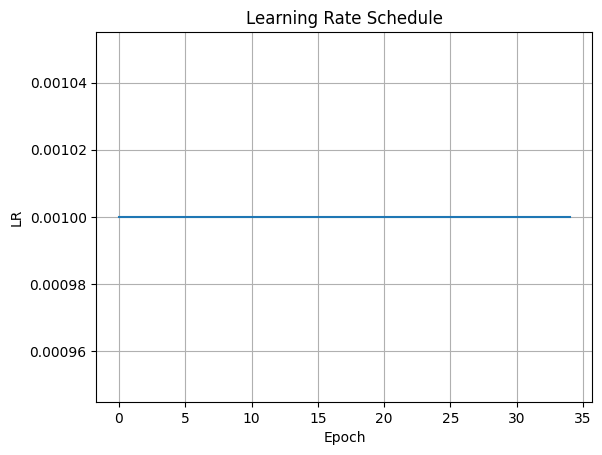

NN Report Fold 1:
               precision    recall  f1-score   support

           0     0.8727    0.8421    0.8571        57
           1     0.6000    0.5000    0.5455        12
           2     0.5385    0.7241    0.6176        29
           3     0.7059    0.5217    0.6000        23
           4     0.6316    0.6667    0.6486        18
           5     0.7273    0.7059    0.7164        34

    accuracy                         0.7110       173
   macro avg     0.6793    0.6601    0.6642       173
weighted avg     0.7219    0.7110    0.7118       173

CatBoost Report Fold 1:
               precision    recall  f1-score   support

           0     0.9434    0.8772    0.9091        57
           1     0.5455    0.5000    0.5217        12
           2     0.6923    0.6207    0.6545        29
           3     0.7037    0.8261    0.7600        23
           4     0.7500    0.8333    0.7895        18
           5     0.8056    0.8529    0.8286        34

    accuracy                     

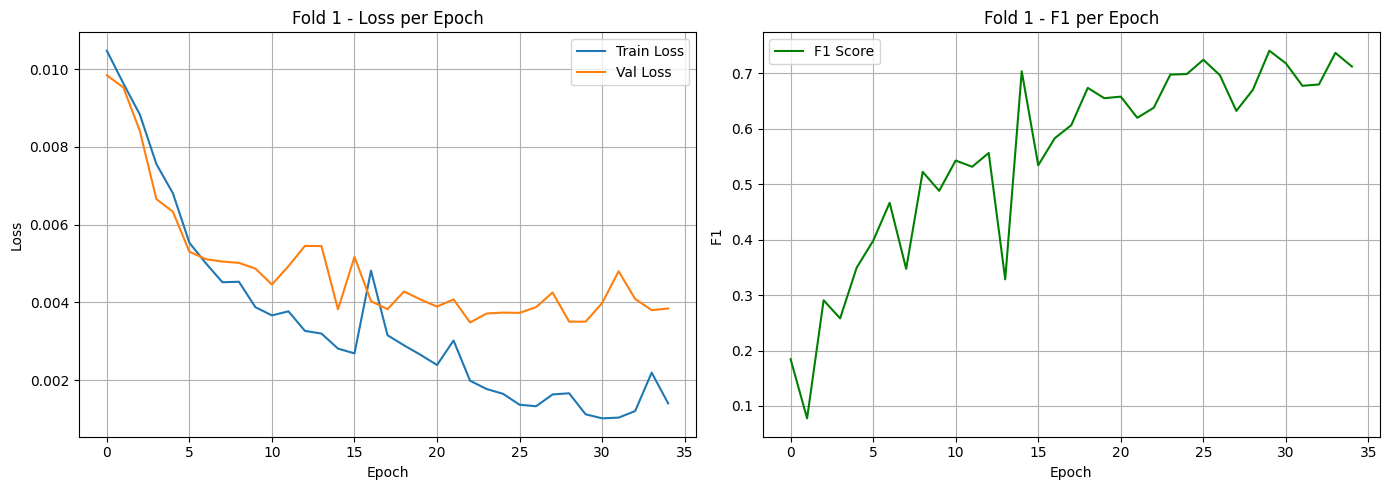


🔁 Fold 2/5


KeyboardInterrupt: 

In [129]:
# === Предобработка данных ===


X_nn = full_dataset.drop(columns=['label'])
y_nn = full_dataset['label']
X_cat = res___.drop(columns=['label'])
y_cat = res___['label']


label_encoder = LabelEncoder()
y_nn = label_encoder.fit_transform(y_nn)
y_cat = label_encoder.transform(y_cat)

# Разделение на train+val и test
X_train_val_nn, X_test_nn, y_train_val_nn, y_test_nn = train_test_split(
    X_nn, y_nn, test_size=0.15, random_state=42, stratify=y_nn)
X_train_val_cat, X_test_cat, y_train_val_cat, y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.15, random_state=42, stratify=y_cat)

# === Гиперпараметры ===
n_splits = 5
num_epochs = 35
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Хранилища результатов ===
all_nn_logits = []
all_cat_logits = []
all_labels = []
f1_scores_per_fold_nn = []
f1_scores_per_fold_cat = []

# === Графики по фолдам ===
all_train_losses = []
all_f1_scores = []
all_val_losses = []
all_val_f1_scores = []

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val_nn, y_train_val_nn)):
    y_val_fold = y_train_val_nn[val_idx]
    values, counts = np.unique(y_val_fold, return_counts=True)
    print(f"\n🔁 Fold {fold + 1}/{n_splits}")

    # Подготовка NN данных
    X_train_np_nn = X_train_val_nn.iloc[train_idx].values
    X_val_np_nn = X_train_val_nn.iloc[val_idx].values
    y_train_np_nn = y_train_val_nn[train_idx].astype(np.int64)
    y_val_np_nn = y_train_val_nn[val_idx].astype(np.int64)

    X_train_np_nn = normalize_signals(X_train_np_nn)
    X_val_np_nn = normalize_signals(X_val_np_nn)

    X_train_tensor_nn = torch.tensor(X_train_np_nn, dtype=torch.float32)
    y_train_tensor_nn = torch.tensor(y_train_np_nn, dtype=torch.long)
    X_val_tensor_nn = torch.tensor(X_val_np_nn, dtype=torch.float32)
    y_val_tensor_nn = torch.tensor(y_val_np_nn, dtype=torch.long)

    train_loader_nn = DataLoader(TensorDataset(X_train_tensor_nn, y_train_tensor_nn), batch_size=batch_size, shuffle=True)
    val_loader_nn = DataLoader(TensorDataset(X_val_tensor_nn, y_val_tensor_nn), batch_size=batch_size, shuffle=False)

    model = Specnaz_gru_plus_norm(input_size=721, num_classes=6).to(device)
    # criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
    criterion = FocalLoss(alpha=weights,gamma=1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.0002)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=1, T_mult=1, eta_min=1e-3
    )

    # === Для графиков ===
    train_losses = []
    f1_scores = []
    val_losses_per_epoch = []
    val_f1_per_epoch = []
    lrs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss_epoch = []
        for inputs, labels in train_loader_nn:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss_epoch.append(loss.item())
        scheduler.step()
        lrs.append(optimizer.param_groups[0]['lr'])

        # === Валидация ===
        model.eval()
        val_preds = []
        val_targets = []
        val_loss_epoch = []
        with torch.no_grad():
            for inputs, labels in val_loader_nn:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss_epoch.append(loss.item())
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        avg_train_loss = np.mean(train_loss_epoch)
        avg_val_loss = np.mean(val_loss_epoch)
        val_f1_nn = f1_score(val_targets, val_preds, average='weighted')

        train_losses.append(avg_train_loss)
        val_losses_per_epoch.append(avg_val_loss)
        f1_scores.append(val_f1_nn)
        val_f1_per_epoch.append(val_f1_nn)
    plt.plot(lrs)
    plt.title("Learning Rate Schedule")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.grid(True)
    plt.show()

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses_per_epoch)
    all_f1_scores.append(val_f1_per_epoch)
    # === Финальная валидация ===
    val_logits = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in val_loader_nn:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            val_logits.append(probs.cpu())

    nn_fold_logits = torch.cat(val_logits).numpy()
    all_nn_logits.append(nn_fold_logits)
    
    # === CatBoost ===
    X_train_np_cat = X_train_val_cat.iloc[train_idx].values
    X_val_np_cat = X_train_val_cat.iloc[val_idx].values
    y_train_np_cat = y_train_val_cat[train_idx]
    y_val_np_cat = y_train_val_cat[val_idx]

    cat_model = CatBoostClassifier(verbose=0, iterations=2000, early_stopping_rounds=50,loss_function = 'MultiClass',eval_metric='MultiClass',random_seed=42,class_weights=weights_cat)
    cat_model.fit(X_train_np_cat, y_train_np_cat, eval_set=(X_val_np_cat, y_val_np_cat))
    cat_probs = cat_model.predict_proba(X_val_np_cat)
    cat_preds = np.argmax(cat_probs, axis=1)
    cat_f1 = f1_score(y_val_np_cat, cat_preds, average='weighted')
    all_cat_logits.append(cat_probs)

    all_labels.append(y_val_np_nn)
    f1_scores_per_fold_nn.append(val_f1_nn)
    f1_scores_per_fold_cat.append(cat_f1)
    torch.save(model.state_dict(), f"nn_model_fold{fold}.pth")
    cat_model.save_model(f"catboost_model_fold{fold}.cbm")
    print(f"NN Report Fold {fold+1}:\n", classification_report(y_val_np_nn, np.argmax(nn_fold_logits, axis=1), digits=4))
    print(f"CatBoost Report Fold {fold+1}:\n", classification_report(y_val_np_cat, np.argmax(cat_probs, axis=1), digits=4))
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)  # Два подграфика
    plt.plot(all_train_losses[fold], label='Train Loss')
    plt.plot(all_val_losses[fold], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold+1} - Loss per Epoch")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(all_f1_scores[fold], label='F1 Score', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("F1 ")
    plt.title(f"Fold {fold+1} - F1 per Epoch")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [115]:
def extract_meta_features(probs):
    """Улучшенное извлечение мета-признаков с нормализацией"""
    eps = 1e-8
    top1 = np.max(probs, axis=1, keepdims=True)
    top2 = np.partition(probs, -2, axis=1)[:, -2][:, None]
    top2_gap = (top1 - top2) / (top1 + eps)  # Нормализованная разница
    
    entropy = -np.sum(probs * np.log(probs + eps), axis=1, keepdims=True)
    max_entropy = np.log(probs.shape[1])  # Максимально возможная энтропия
    norm_entropy = entropy / max_entropy  # Нормализованная энтропия [0,1]
    
    uncertainty = 1 - top1  # Мера неопределенности
    
    return np.concatenate([
        probs,                 # Исходные вероятности
        top2,
        top2_gap,
        norm_entropy,
        uncertainty
    ], axis=1)

# Пример использования:
meta_nn = [extract_meta_features(logits) for logits in all_nn_logits]
meta_cat = [extract_meta_features(logits) for logits in all_cat_logits]

# Альтернативный вариант конкатенации с взаимодействием моделей
X_meta = np.concatenate([
    np.concatenate(meta_nn, axis=0),
    np.concatenate(meta_cat, axis=0) 
], axis=1)
y_meta = np.concatenate(all_labels, axis=0)

In [116]:
def choose_best_or_ensemble(val_f1_per_fold, threshold=0.075): 
    best_fold_idx = np.argmax(val_f1_per_fold)
    best_f1 = val_f1_per_fold[best_fold_idx] 
    mean_f1 = np.mean(val_f1_per_fold)
    
    # Если лучший фолд существенно лучше среднего (на threshold), то выбираем его
    if best_f1 - mean_f1 > threshold:
        print(f"Выбираем лучшую модель (фолд {best_fold_idx}) с F1={best_f1:.4f},средний({mean_f1:.4f})")
        return 'best_model', best_fold_idx
    else:
        print(f"Используем усреднение (ансамбль), средний F1={mean_f1:.4f},лучший({best_f1:.4f})")
        return 'ensemble', None
    
mode_nn, best_fold_nn_idx = choose_best_or_ensemble(f1_scores_per_fold_nn)
mode_cat, best_fold_cat_idx = choose_best_or_ensemble(f1_scores_per_fold_cat)

Используем усреднение (ансамбль), средний F1=0.7566,лучший(0.7844)
Используем усреднение (ансамбль), средний F1=0.7666,лучший(0.8044)


In [117]:
def make_meta_test(mode_nn,mode_cat,best_fold_nn_idx,best_fold_cat_idx,X_test_nn,X_test_cat,device):
    if mode_nn == 'best_model':
        model_nn = Specnaz_gru_plus_norm(721,num_classes=6).to(device)
        model_nn.load_state_dict(torch.load( f"nn_model_fold{best_fold_nn_idx}.pth"))
        model_nn.eval()

        with torch.no_grad():
            inputs = torch.tensor(normalize_signals(X_test_nn.values),dtype=torch.float32).to(device)
            outputs = model_nn(inputs)
            nn_probs = torch.softmax(outputs,dim=1).cpu().numpy()
    else:
        test_logits_nn_list = []
        X_test_nn_np = normalize_signals(X_test_nn.values)
        X_test_tensor = torch.tensor(X_test_nn_np, dtype=torch.float32).to(device)

        for fold in range(n_splits):
            model = Specnaz_gru_plus_norm(input_size=721, num_classes=6).to(device)
            model.load_state_dict(torch.load(f"nn_model_fold{fold}.pth"))
            model.eval()

            fold_logits = []
            with torch.no_grad():
                for i in range(0, len(X_test_tensor), batch_size):
                    batch = X_test_tensor[i:i+batch_size]
                    output = model(batch)
                    probs = torch.softmax(output, dim=1)
                    fold_logits.append(probs.cpu())

            fold_logits = torch.cat(fold_logits).numpy()
            test_logits_nn_list.append(fold_logits)
        nn_probs = np.mean(test_logits_nn_list, axis=0)
    
    if mode_cat == 'best_model':
        model_cat = CatBoostClassifier()
        model_cat.load_model(f"catboost_model_fold{best_fold_cat_idx}.cbm")
        cat_probs = cat_model.predict_proba(X_test_cat)
    else:
        cat_test_probs_list     = []
        for fold in range(n_splits):
            model_cat = CatBoostClassifier()
            model_cat.load_model(f"catboost_model_fold{fold}.cbm")
            probs = model_cat.predict_proba(X_test_cat.values)
            cat_test_probs_list.append(probs)
        cat_probs = np.mean(cat_test_probs_list, axis=0)
    nn_meta = extract_meta_features(nn_probs)
    cat_meta = extract_meta_features(cat_probs)
    return np.concatenate([nn_meta,cat_meta],axis=1)



In [118]:
class meta_notfix(nn.Module):
    def __init__(self, input=20, output=6):
        super(meta_notfix, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),           
            nn.Dropout(0.4),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.4),

            nn.Linear(256, output) 
        )

    def forward(self, x):
        return self.model(x)

Epoch [1/25], Train Loss: 70.7645
Epoch [1/25], Validation Loss: 16.1799, Validation Accuracy: 0.67%, F1-score: 0.6638
Epoch [6/25], Train Loss: 34.2693
Epoch [6/25], Validation Loss: 7.8344, Validation Accuracy: 0.79%, F1-score: 0.7935
Epoch [11/25], Train Loss: 30.5217
Epoch [11/25], Validation Loss: 6.2755, Validation Accuracy: 0.82%, F1-score: 0.8170
Epoch [16/25], Train Loss: 26.9677
Epoch [16/25], Validation Loss: 5.7751, Validation Accuracy: 0.83%, F1-score: 0.8335
Epoch [21/25], Train Loss: 25.8681
Epoch [21/25], Validation Loss: 5.6456, Validation Accuracy: 0.83%, F1-score: 0.8339
Epoch [25/25], Train Loss: 25.6090
Epoch [25/25], Validation Loss: 5.5564, Validation Accuracy: 0.84%, F1-score: 0.8394
              precision    recall  f1-score   support

           0     0.9231    0.8421    0.8807        57
           1     0.6429    0.7500    0.6923        12
           2     0.7586    0.7586    0.7586        29
           3     0.8077    0.9130    0.8571        23
           4

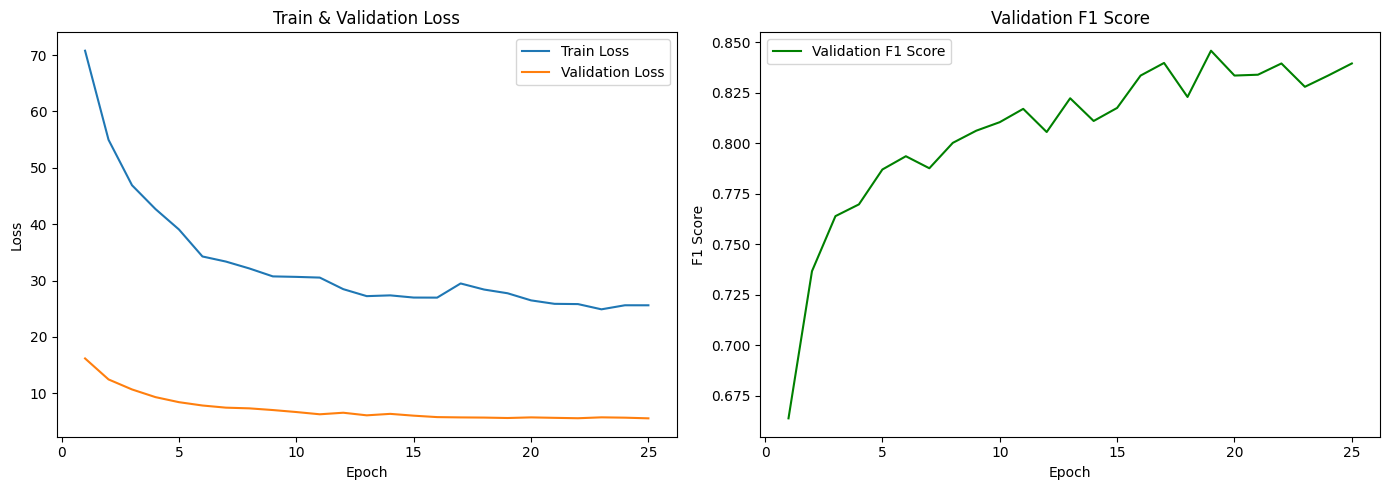

In [127]:
# Оберни X_meta и y_meta в тензоры
X_meta_train, X_meta_val, y_meta_train, y_meta_val = train_test_split(
    X_meta, y_meta, test_size=0.2, random_state=42, stratify=y_meta
)
X_meta_train_tensor = torch.tensor(X_meta_train, dtype=torch.float32)
y_meta_train_tensor = torch.tensor(y_meta_train, dtype=torch.long)
X_meta_val_tensor = torch.tensor(X_meta_val, dtype=torch.float32)
y_meta_val_tensor = torch.tensor(y_meta_val, dtype=torch.long)

meta_train_dataset = TensorDataset(X_meta_train_tensor, y_meta_train_tensor)
meta_val_dataset = TensorDataset(X_meta_val_tensor, y_meta_val_tensor)

meta_train_loader = DataLoader(meta_train_dataset, batch_size=16, shuffle=True,drop_last=False)
meta_val_loader = DataLoader(meta_val_dataset, batch_size=16, shuffle=False,drop_last=False)
# Объяви модель
meta_model = meta_notfix(input=20, output=6).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss()
optimizer = torch.optim.AdamW(meta_model.parameters(), lr=1e-4)



best_f1 = 0.0
best_model_state = None
num_epochs_meta = 25

train_losses = []
val_losses = []
val_f1_scores = []
for epoch in range(num_epochs_meta):
    # Тренировка
    meta_model.train()
    total_train_loss = 0
    for inputs, labels in meta_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = meta_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    # Валидация
    meta_model.eval()
    total_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in meta_val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = meta_model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            val_preds.append(probs.cpu().numpy())
            val_labels.append(labels.cpu().numpy())
    
    val_preds = np.concatenate(val_preds, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    val_preds_classes = np.argmax(val_preds, axis=1)
    val_accuracy = (val_preds_classes == val_labels).mean()
    val_f1 = f1_score(val_labels, val_preds_classes, average='weighted')

    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)
    val_f1_scores.append(val_f1)


    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_state = meta_model.state_dict()

    if epoch%5 == 0 or epoch == num_epochs_meta-1:
        print(f"Epoch [{epoch+1}/{num_epochs_meta}], Train Loss: {total_train_loss:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs_meta}], Validation Loss: {total_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, F1-score: {val_f1:.4f}")
print(classification_report(val_labels, val_preds_classes, digits=4))

epochs = range(1, num_epochs_meta + 1)


plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss')
plt.legend()

# F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs, val_f1_scores, label='Validation F1 Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [128]:
X_metat = make_meta_test(mode_nn,mode_cat,best_fold_nn_idx,best_fold_cat_idx,X_test_nn,X_test_cat,device)
meta_model.load_state_dict(best_model_state)
meta_model.eval()
X_meta_test_tensor = torch.tensor(X_metat, dtype=torch.float32).to(device)
meta_preds = []
with torch.no_grad():
    for i in range(0, len(X_meta_test_tensor), batch_size):
        batch = X_meta_test_tensor[i:i+batch_size]
        out = meta_model(batch)
        probs = torch.softmax(out, dim=1)
        pred = torch.argmax(probs, dim=1)
        meta_preds.extend(pred.cpu().numpy())

meta_preds = np.array(meta_preds)

# === Метки ===
print("Meta Test Classification Report:")
print(classification_report(y_test_cat, meta_preds, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test_cat, meta_preds))

Meta Test Classification Report:
              precision    recall  f1-score   support

           0     0.9259    0.9804    0.9524        51
           1     0.5625    0.8182    0.6667        11
           2     0.9444    0.6800    0.7907        25
           3     1.0000    0.8000    0.8889        20
           4     0.8235    0.8750    0.8485        16
           5     0.8750    0.9333    0.9032        30

    accuracy                         0.8758       153
   macro avg     0.8552    0.8478    0.8417       153
weighted avg     0.8918    0.8758    0.8766       153

Confusion Matrix:
 [[50  1  0  0  0  0]
 [ 1  9  1  0  0  0]
 [ 3  5 17  0  0  0]
 [ 0  1  0 16  1  2]
 [ 0  0  0  0 14  2]
 [ 0  0  0  0  2 28]]


In [ ]:
def hello():
    pass